# IMPORTS

In [1]:

import pandas as pd
import time
from datetime import datetime, date
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype

from collections import OrderedDict
import pytz

import warnings
warnings.filterwarnings("ignore")

# LOAD DATA

In [2]:
# Downloaded data from https://www.cryptodatadownload.com/data/binance/
test_data = pd.read_csv('data/Binance_BTCUSDT_1h.csv')
display(test_data.head())
display(test_data.tail())

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1.648771e+12,2022-04-01 00:00:00,BTC/USDT,45510.35,45644.86,45365.33,45384.58,1039.94279,4.736787e+07,31470.0
1,1.648768e+12,2022-03-31 23:00:00,BTC/USDT,45787.85,45787.86,45200.00,45510.34,2889.28168,1.314323e+08,62276.0
2,1.648764e+12,2022-03-31 22:00:00,BTC/USDT,45757.19,45820.34,45660.68,45787.85,1058.12591,4.840908e+07,32731.0
3,1.648760e+12,2022-03-31 21:00:00,BTC/USDT,45745.45,45849.99,45647.01,45757.19,887.89890,4.063375e+07,30025.0
4,1.648757e+12,2022-03-31 20:00:00,BTC/USDT,45581.98,45790.00,45519.03,45745.46,1550.11357,7.076137e+07,40487.0


,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
40483,1.502957e+09,2017-08-17 08-AM,BTC/USDT,4349.99,4377.85,4333.32,4360.69,0.9499,4139.70,NaN
40484,1.502953e+09,2017-08-17 07-AM,BTC/USDT,4324.35,4349.99,4287.41,4349.99,4.4400,19241.06,NaN
40485,1.502950e+09,2017-08-17 06-AM,BTC/USDT,4315.32,4345.45,4309.37,4324.35,7.2300,31282.31,NaN
40486,1.502946e+09,2017-08-17 05-AM,BTC/USDT,4308.83,4328.69,4291.37,4315.32,23.2300,100304.82,NaN
40487,1.502942e+09,2017-08-17 04-AM,BTC/USDT,16199.91,16199.91,4261.32,4308.83,44.5100,190952.85,NaN


# CONFIG

In [3]:
scrip = 'BTC'
scrip_name = 'BITCOIN'

# NOTE: Set the timezone for which you want to do the analysis
# Set to None if local timezone has to be applied
# Some timezones: 'UTC','GMT','America/New_York','Asia/Kolkata'
# Run `pytz.all_timezones` to get the list of all supported timezones
ANALYSIS_TIMEZONE = 'UTC'


INPUT_HOURLY_DATA_FILEPATH = f'data/Binance_{scrip}USDT_1h.csv'
VOLUME_COLUMN = f'Volume {scrip}'

ANALYSIS_START_DATE = date(2021,1,1) 
ANALYSIS_END_DATE = date(2021,12,31)
TEST_START_DATE = date(2022,1,1)
TEST_END_DATE = date(2022,3,31)

FEATURES_COLUMNS = ['open','close', VOLUME_COLUMN]
DAYS_OF_WEEK =[ "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
WEEKEND_DAYS = ['Saturday','Sunday']
WEEKDAY_DAYS =["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

SORTED_DAYS_OF_WEEK = [ "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

DAYS_OF_WEEK_CAT = CategoricalDtype(SORTED_DAYS_OF_WEEK, ordered=True)

INVESTMENT_AMOUNT_DOLLARS = 500

# UTILITY FUNCTIONS

## DATA PREPROCESSING FUNCTIONS

### CORRECT DATETIME

In [4]:
def update_actual_date(unix_epoch, timezone):
    
    unix_epoch_value = unix_epoch/1000 if (len(str(int(unix_epoch))) == 13) else unix_epoch
    
    if timezone is not None:
        return datetime.fromtimestamp(unix_epoch_value, pytz.timezone(timezone))
    else:
        return datetime.fromtimestamp(unix_epoch_value)
        


def set_actual_date(data_df):
    # Set the datetime column
    data_df['actual_date'] = data_df['unix'].apply(lambda x: update_actual_date(x,ANALYSIS_TIMEZONE))
    return data_df


### FILTER DATA

In [5]:
def preprocess(scrip_df, start_date, end_date = '2030-01-01'):
    
    # Filter data based on the start and end data
    scrip_df = scrip_df[(scrip_df['actual_date'].dt.date>=start_date) & (scrip_df['actual_date'].dt.date<=end_date)]
    
    # Sort data based on the date
    scrip_df.sort_values(by=['actual_date'], ascending = False, inplace=True)

    # Set date as Index. Keep only the close price.
    scrip_df.set_index('actual_date', drop=True,inplace=True)
    
    
    # Keep only the required columns and drop the rest
    scrip_df = scrip_df[FEATURES_COLUMNS]
    
    return scrip_df

## FEATURE ENGINEERING

### ADD HOUR, DAY OF THE WEEK & WEEK NUMBER

In [6]:

def get_day_of_week(row):
    return DAYS_OF_WEEK[row.name.weekday()]

def get_week(row):
    return row.name.isocalendar().week


def get_hour(row):
    return row.name.time().hour
    
def add_timestamp_features(scrip_df,add_hours=True):

    scrip_df['day'] = scrip_df.apply(lambda x: get_day_of_week(x),axis=1).astype(DAYS_OF_WEEK_CAT)
    scrip_df['week'] = scrip_df.apply(lambda x: get_week(x),axis=1)
    
    if add_hours:
        scrip_df['hour'] = scrip_df.apply(lambda x: get_hour(x),axis=1)
    
    return scrip_df

In [7]:

# mydf = pd.read_csv(INPUT_HOURLY_DATA_FILEPATH)
# mydf = set_actual_date(mydf)

# print(f'Shape - initial:{mydf.shape}')
# mydf = preprocess(mydf, ANALYSIS_START_DATE, ANALYSIS_END_DATE)
# print(f'Shape - after preprocess:{mydf.shape}')
# mydf = add_timestamp_features(mydf)
# print(f'Shape - after adding features:{mydf.shape}')
# display(mydf.head())
# display(mydf.tail())

### ADD PROFIT/LOSS FOR THE CANDLE

In [8]:
def add_profitloss_features(scrip_df):
    scrip_df['closed_green'] = scrip_df['close'] > scrip_df['open']
    scrip_df['closed'] = scrip_df.apply(lambda x: 'GREEN' if (x['close'] >= x['open']) else 'RED',axis=1)
    scrip_df['profit_pct'] = (scrip_df['close'] - scrip_df['open'])/scrip_df['open'] * 100
    return scrip_df

### ADD NEXT CANDLES

In [9]:
def add_next_open_features(scrip_df):
    scrip_df['next2_open'] = scrip_df['open'].shift(2)
    scrip_df['next2_opened'] = scrip_df.apply(lambda x: 'GREEN' if (x['next2_open'] >= x['open']) else 'RED',axis=1)
    
    
    scrip_df['next3_open'] = scrip_df['open'].shift(3)
    scrip_df['next3_opened'] = scrip_df.apply(lambda x: 'GREEN' if (x['next3_open'] >= x['open']) else 'RED',axis=1)
    
    # 4-hour window
    scrip_df['next4_open'] = scrip_df['open'].shift(4)
    scrip_df['next4_opened'] = scrip_df.apply(lambda x: 'GREEN' if (x['next4_open'] >= x['open']) else 'RED',axis=1)
    
    # 6-hour window
    scrip_df['next6_open'] = scrip_df['open'].shift(6)
    scrip_df['next6_opened'] = scrip_df.apply(lambda x: 'GREEN' if (x['next6_open'] >= x['open']) else 'RED',axis=1)
    
    # 8-hour window
    scrip_df['next8_open'] = scrip_df['open'].shift(8)
    scrip_df['next8_opened'] = scrip_df.apply(lambda x: 'GREEN' if (x['next8_open'] >= x['open']) else 'RED',axis=1)
    
    # 12-hour window
    scrip_df['next12_open'] = scrip_df['open'].shift(12)
    scrip_df['next12_opened'] = scrip_df.apply(lambda x: 'GREEN' if (x['next12_open'] >= x['open']) else 'RED',axis=1)
    
    # 24-hour window
    scrip_df['next24_open'] = scrip_df['open'].shift(24)
    scrip_df['next24_opened'] = scrip_df.apply(lambda x: 'GREEN' if (x['next24_open'] >= x['open']) else 'RED',axis=1)
    
    # 48-hour window
    scrip_df['next48_open'] = scrip_df['open'].shift(48)
    scrip_df['next48_opened'] = scrip_df.apply(lambda x: 'GREEN' if (x['next48_open'] >= x['open']) else 'RED',axis=1)
    
    return scrip_df



## FIND PATTERNS

### PATTERN BASED ON WINDOW PERIOD

In [10]:
def get_grouped_data(scrip_df, closed_col, groupbyday):
    group_cols = ['day','hour',closed_col] if groupbyday else ['hour',closed_col] 
    return pd.DataFrame(scrip_df.groupby(group_cols).size().reset_index())
    
def get_window_range(hr, window_period):
    end_time = f'-{(hr+window_period)%24}:00' if window_period < 24 \
        else f'+{int(window_period/24)}d' 
    return f'{hr}:00{end_time}'
    
def get_pattern_for_window(scrip_df, groupbyday = True, window_period = 1): #closed_col = 'closed'):
    closed_col = 'closed' if (window_period == 1) else f'next{window_period}_opened'
    closed_df = get_grouped_data(scrip_df,  closed_col, groupbyday)
    closed_df.rename(columns = {0:'count'},inplace = True)    
    merge_cols = ['day','hour'] if groupbyday else ['hour']

    closed_total = pd.DataFrame(scrip_df.groupby(merge_cols).size().reset_index())
    closed_df = pd.merge(closed_df, closed_total, how='left', on=merge_cols)
    
    closed_df.rename(columns = {0:'total',closed_col:'profit_or_loss'},inplace = True)
    
    
    closed_df['hours'] = closed_df['hour'].apply(lambda x: get_window_range(x, window_period))
    closed_df['window'] = window_period
        
    closed_df['percent'] = round(closed_df['count']/closed_df['total']*100,2)
    closed_df.sort_values('percent',ascending=False, inplace=True)
    
    final_cols = ['day','hours','window','profit_or_loss','percent'] if groupbyday else ['hours','window','profit_or_loss','percent']
    return closed_df[final_cols]
   


## PLOTS

### PLOT BAR CHART

In [11]:
def plot_data_bar(chart_df,y_col, title_string, x_label, y_label, palette_type = 'hls', 
                  show_yvalue = False, ylimmax = None, xticks_rotate = None):
    f, ax = plt.subplots(figsize=(16,8))
    ax = sns.barplot(x=chart_df.index, y=chart_df[y_col],palette = palette_type)
    ax.set( xlabel=x_label,ylabel=y_label,title = title_string)
    
    if ylimmax is not None:
        plt.ylim(ymax = ylimmax)
    
    if xticks_rotate is not None:
        plt.xticks(rotation=xticks_rotate, ha='right')
        
        
    if show_yvalue:
        
        for i in ax.containers:
            ax.bar_label(i,)
            
            
    plt.show()

### PLOT THE BEST TIME TO TRADE BAR CHART

In [12]:
def plot_best_time_window(best_window_df, title_string, hue_colors = None):
    sns.set(style="white", context="talk")
    f, ax = plt.subplots(figsize=(16,10))
    if hue_colors is None:
        hue_colors = {'RED': "red", 'GREEN': "forestgreen"}
    ax = sns.barplot(x="day", y="percent", hue="profit_or_loss", data=best_window_df,palette = hue_colors)
    ax.set( xlabel='Day',ylabel='Percentage',title = f'BEST TIME TO TRADE - {title_string}')
    plt.ylim(ymax = 100, ymin = 0)
    plt.legend().remove()

    # Sort patches based on the rectangle's x value 
    # (patches are not in order by default and labels don't match otherwise)
    patches_dict = {}
    for i, p in enumerate(ax.patches):
        patches_dict[p.get_x()] = p
    sorted_patches = OrderedDict(sorted(patches_dict.items()))
    i = 0
    for px, p in sorted_patches.items():
        ax.text(p.get_x()+p.get_width()/2., p.get_height() + 1, 
                f"{int(best_window_df.loc[i]['percent'])}%",ha="center")
        ax.text(p.get_x()+p.get_width()/2., p.get_height() + 8, 
                f"{best_window_df.loc[i]['hours']}",ha="center", rotation=90)
        i += 1

    plt.show()
     

def display_window_pattern(pattern_df, title_string):
    best_window_data = pattern_df.sort_values(['percent','profit_or_loss'], ascending=False) \
                               .drop_duplicates(['day','profit_or_loss']) 
    
    best_window_data = best_window_data.sort_values(['day','profit_or_loss']).reset_index(drop=True) 
    plot_best_time_window(best_window_data,title_string)
    return best_window_data
    


# HOURLY DATA ANALYSIS

## LOAD THE DATA

In [13]:

complete_1h_df = pd.read_csv(INPUT_HOURLY_DATA_FILEPATH)
complete_1h_df = set_actual_date(complete_1h_df)

print(f'Shape - initial:{complete_1h_df.shape}')
scrip_1h_df = preprocess(complete_1h_df, ANALYSIS_START_DATE, ANALYSIS_END_DATE)
print(f'Shape - after preprocess:{scrip_1h_df.shape}')
scrip_1h_df = add_timestamp_features(scrip_1h_df)
scrip_1h_df = add_profitloss_features(scrip_1h_df)
scrip_1h_df = add_next_open_features(scrip_1h_df)

print(f'Shape - after adding features:{scrip_1h_df.shape}')
display(scrip_1h_df.head())
display(scrip_1h_df.tail())

Shape - initial:(40488, 11)
Shape - after preprocess:(8747, 3)
Shape - after adding features:(8747, 25)


,open,close,Volume BTC,day,week,hour,closed_green,closed,profit_pct,next2_open,...,next6_open,next6_opened,next8_open,next8_opened,next12_open,next12_opened,next24_open,next24_opened,next48_open,next48_opened
actual_date,,,,,,,,,,,,,,,,,,,,,
2021-12-31 23:00:00+00:00,46303.98,46216.93,985.99762,Friday,52,23,False,RED,-0.187997,NaN,...,NaN,RED,NaN,RED,NaN,RED,NaN,RED,NaN,RED
2021-12-31 22:00:00+00:00,46333.87,46303.99,991.85142,Friday,52,22,False,RED,-0.064488,NaN,...,NaN,RED,NaN,RED,NaN,RED,NaN,RED,NaN,RED
2021-12-31 21:00:00+00:00,45886.66,46333.86,1734.69585,Friday,52,21,True,GREEN,0.974575,46303.98,...,NaN,RED,NaN,RED,NaN,RED,NaN,RED,NaN,RED
2021-12-31 20:00:00+00:00,45728.28,45879.24,1831.41202,Friday,52,20,True,GREEN,0.330124,46333.87,...,NaN,RED,NaN,RED,NaN,RED,NaN,RED,NaN,RED
2021-12-31 19:00:00+00:00,46686.42,45728.28,3851.30902,Friday,52,19,False,RED,-2.052288,45886.66,...,NaN,RED,NaN,RED,NaN,RED,NaN,RED,NaN,RED


,open,close,Volume BTC,day,week,hour,closed_green,closed,profit_pct,next2_open,...,next6_open,next6_opened,next8_open,next8_opened,next12_open,next12_opened,next24_open,next24_opened,next48_open,next48_opened
actual_date,,,,,,,,,,,,,,,,,,,,,
2021-01-01 04:00:00+00:00,29278.41,29220.31,2038.046803,Friday,53,4,False,RED,-0.198440,29187.01,...,29202.21,RED,29313.49,GREEN,29188.67,RED,29351.95,GREEN,32576.11,GREEN
2021-01-01 03:00:00+00:00,29195.25,29278.40,1461.345077,Friday,53,3,True,GREEN,0.284807,29220.31,...,29000.01,RED,29223.82,GREEN,29327.83,GREEN,29323.82,GREEN,32741.68,GREEN
2021-01-01 02:00:00+00:00,29410.00,29194.65,2384.231560,Friday,53,2,False,RED,-0.732234,29278.41,...,29092.84,RED,29202.21,RED,29464.79,GREEN,29359.46,RED,32583.04,GREEN
2021-01-01 01:00:00+00:00,28995.13,29409.99,5403.068471,Friday,53,1,True,GREEN,1.430792,29195.25,...,29174.35,GREEN,29000.01,GREEN,29233.49,GREEN,29197.93,GREEN,32447.95,GREEN
2021-01-01 00:00:00+00:00,28923.63,28995.13,2311.811445,Friday,53,0,True,GREEN,0.247203,29410.00,...,29187.01,GREEN,29092.84,GREEN,29313.49,GREEN,29331.70,GREEN,32176.45,GREEN


## ANALYSIS

### AVERAGE HOURLY VOLUME TRADED

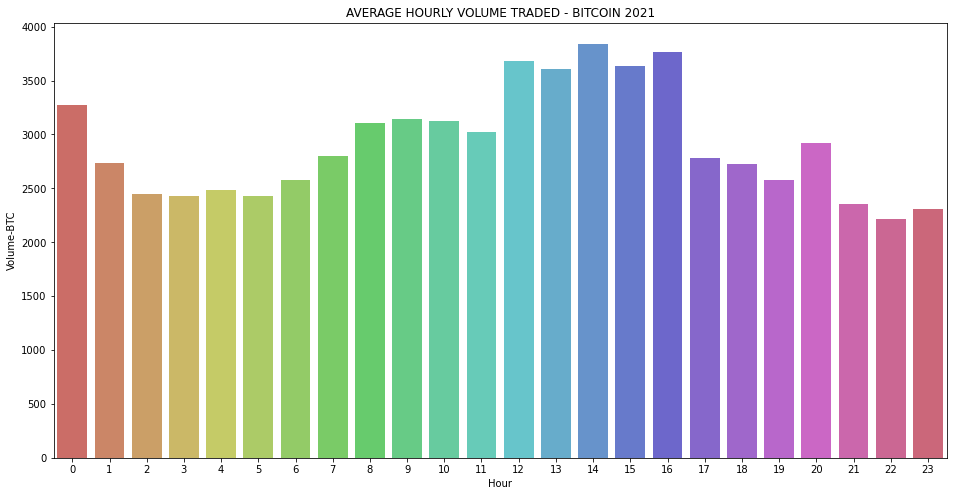

In [14]:
avg_hourly_trade = pd.DataFrame(scrip_1h_df.groupby(['hour'])[VOLUME_COLUMN].mean().sort_values(ascending=False))
avg_hourly_trade.sort_index(inplace=True)
print("\n\n")
plot_data_bar(avg_hourly_trade,VOLUME_COLUMN,f'AVERAGE HOURLY VOLUME TRADED - {scrip_name} 2021','Hour',f'Volume-{scrip}')



### AVERAGE DAILY VOLUME TRADED

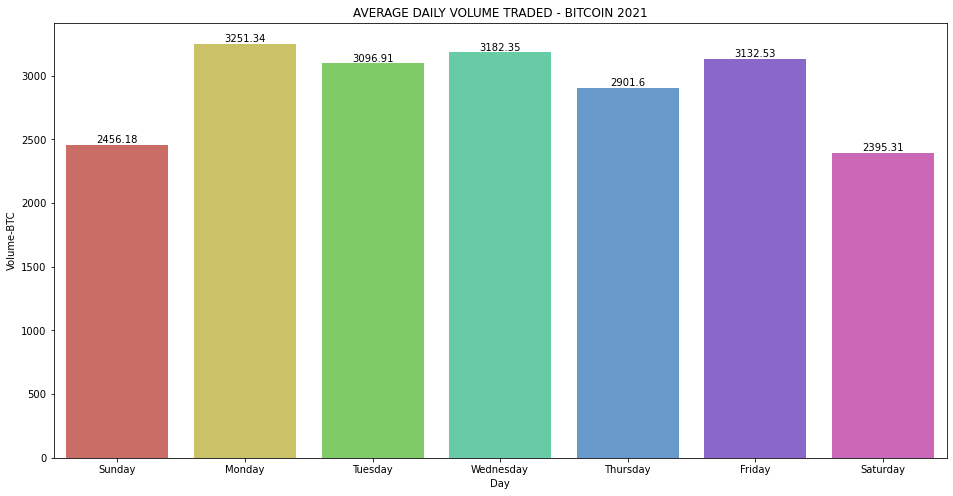

In [15]:
avg_weekly_trade = pd.DataFrame(scrip_1h_df.groupby(['day'])[VOLUME_COLUMN].mean().sort_values(ascending=False))

print("\n\n")
plot_data_bar(avg_weekly_trade.loc[DAYS_OF_WEEK],VOLUME_COLUMN,
              f'AVERAGE DAILY VOLUME TRADED - {scrip_name} 2021','Day',f'Volume-{scrip}', show_yvalue = True)


### AVERAGE HOURLY VOLUME TRADED ON WEEKENDS

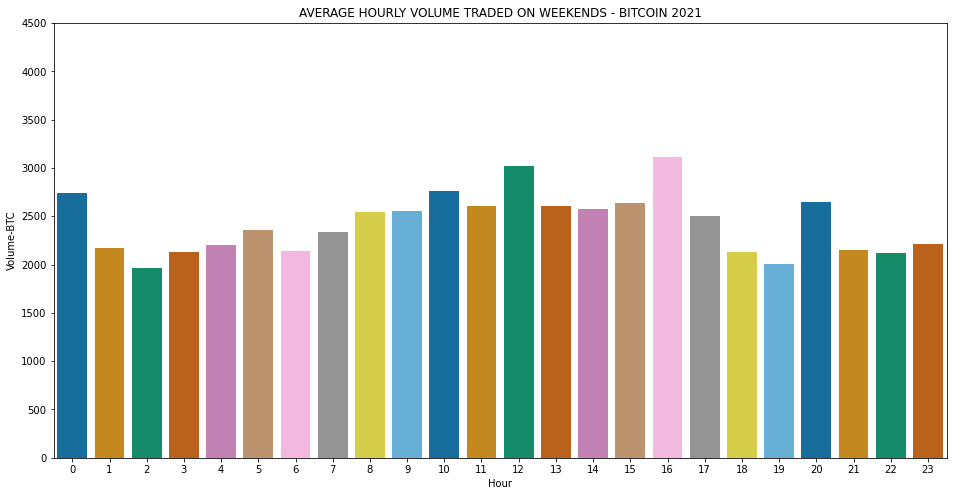

In [16]:
avg_weekend_hourly_trade = pd.DataFrame(scrip_1h_df[scrip_1h_df['day'].isin(WEEKEND_DAYS)].groupby(['hour'])[VOLUME_COLUMN].mean().sort_values(ascending=False))
avg_weekend_hourly_trade.sort_index(inplace=True)
print("\n")
plot_data_bar(avg_weekend_hourly_trade,VOLUME_COLUMN,f'AVERAGE HOURLY VOLUME TRADED ON WEEKENDS - {scrip_name} 2021','Hour',f'Volume-{scrip}',
             palette_type = 'colorblind',ylimmax = 4500)


### AVERAGE HOURLY VOLUME TRADED ON WEEKDAYS

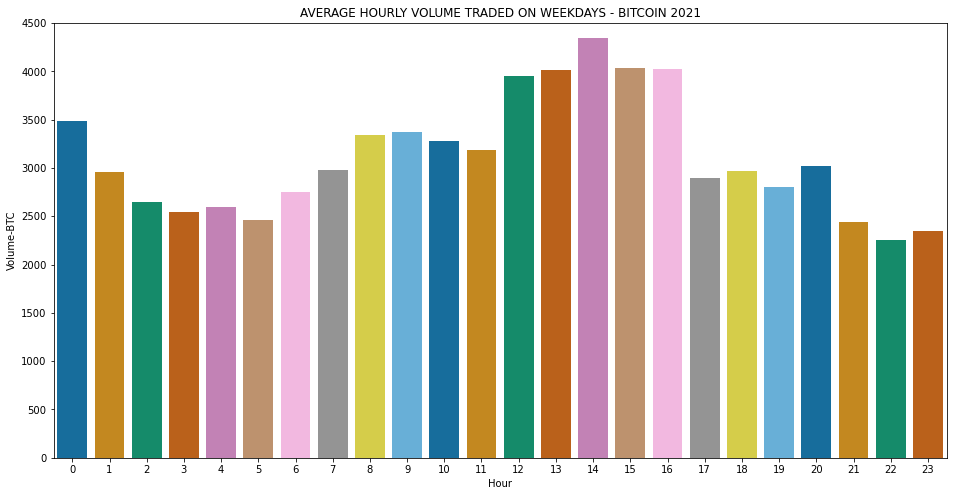

In [17]:
avg_weekdays_hourly_trade = pd.DataFrame(scrip_1h_df[scrip_1h_df['day'].isin(WEEKDAY_DAYS)].groupby(['hour'])[VOLUME_COLUMN].mean().sort_values(ascending=False))
avg_weekdays_hourly_trade.sort_index(inplace=True)
print()
plot_data_bar(avg_weekdays_hourly_trade,VOLUME_COLUMN,f'AVERAGE HOURLY VOLUME TRADED ON WEEKDAYS - {scrip_name} 2021','Hour',f'Volume-{scrip}',
             palette_type = 'colorblind',ylimmax = 4500)




### BEST DAILY TRADING TIME

#### HOURLY WINDOW

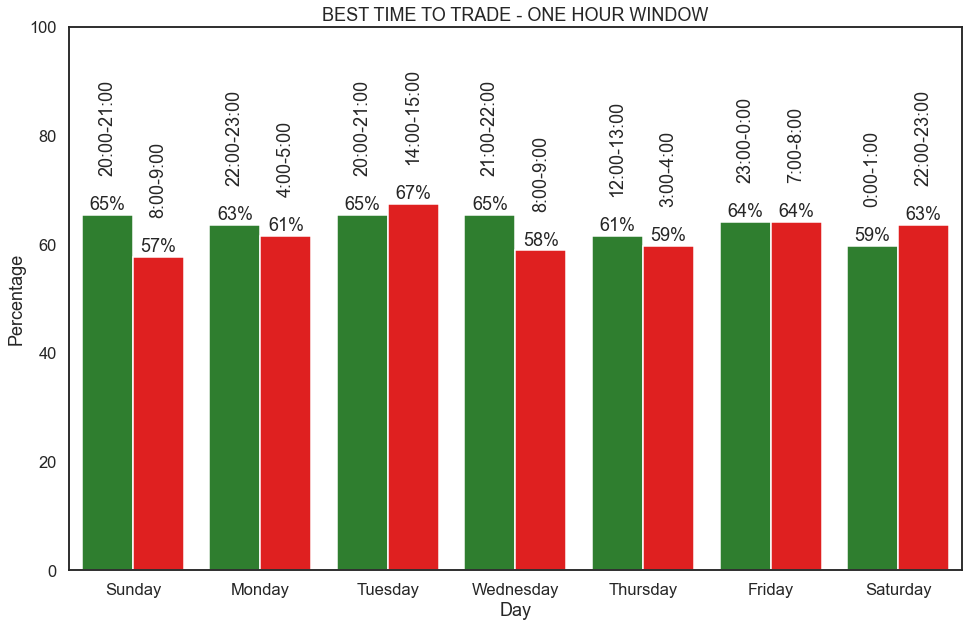

In [18]:
hourly_pattern = get_pattern_for_window(scrip_1h_df,  groupbyday = True, window_period = 1)
best_hourly_pattern = display_window_pattern(hourly_pattern,"ONE HOUR WINDOW")

#### TWO-HOURS WINDOW

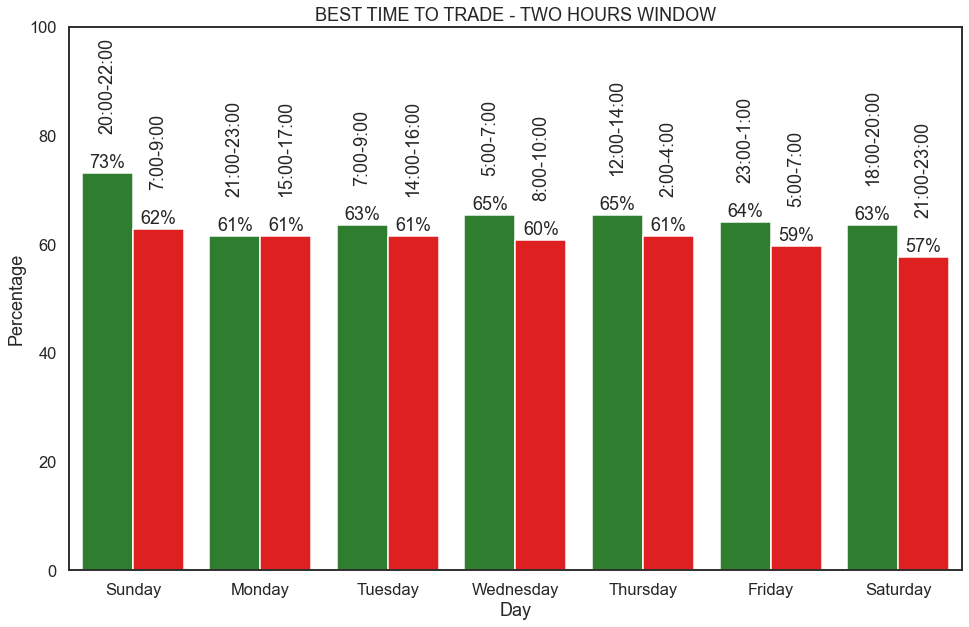

In [19]:
hourly2_pattern = get_pattern_for_window(scrip_1h_df,  groupbyday = True, window_period = 2)
best_hourly2_pattern = display_window_pattern(hourly2_pattern,"TWO HOURS WINDOW")

#### THREE-HOURS WINDOW

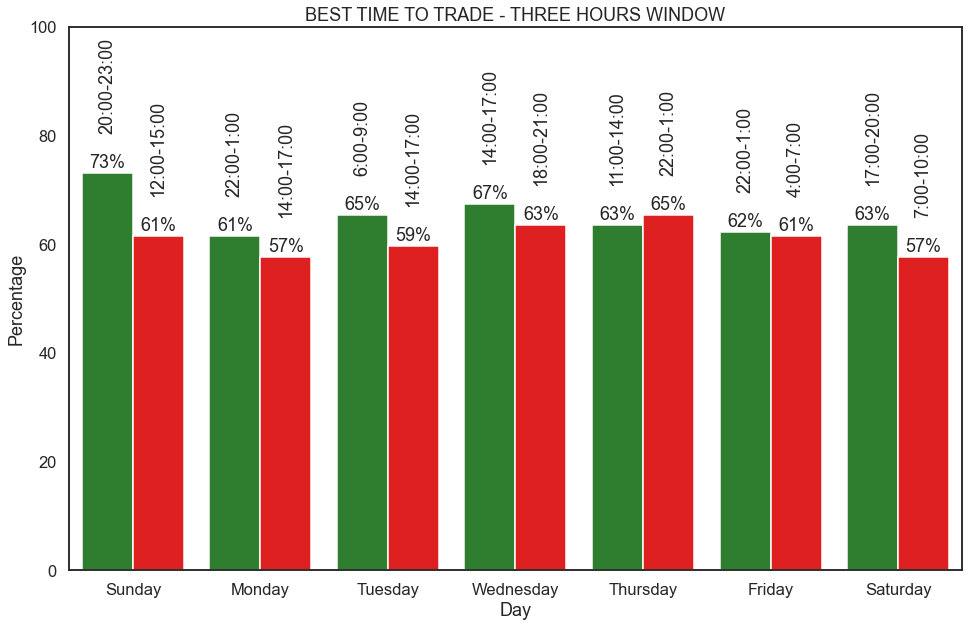

In [20]:
hourly3_pattern = get_pattern_for_window(scrip_1h_df,  groupbyday = True, window_period = 3)
best_hourly3_pattern = display_window_pattern(hourly3_pattern,"THREE HOURS WINDOW")

#### FOUR-HOURS WINDOW

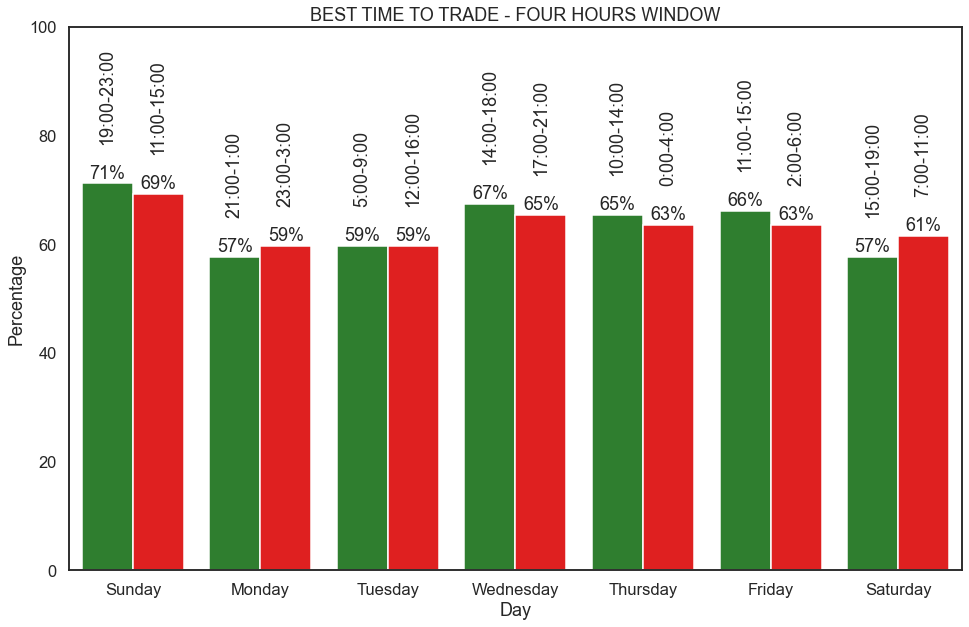

In [21]:
hourly4_pattern = get_pattern_for_window(scrip_1h_df,  groupbyday = True, window_period = 4)
best_hourly4_pattern = display_window_pattern(hourly4_pattern,"FOUR HOURS WINDOW")


#### SIX-HOURS WINDOW

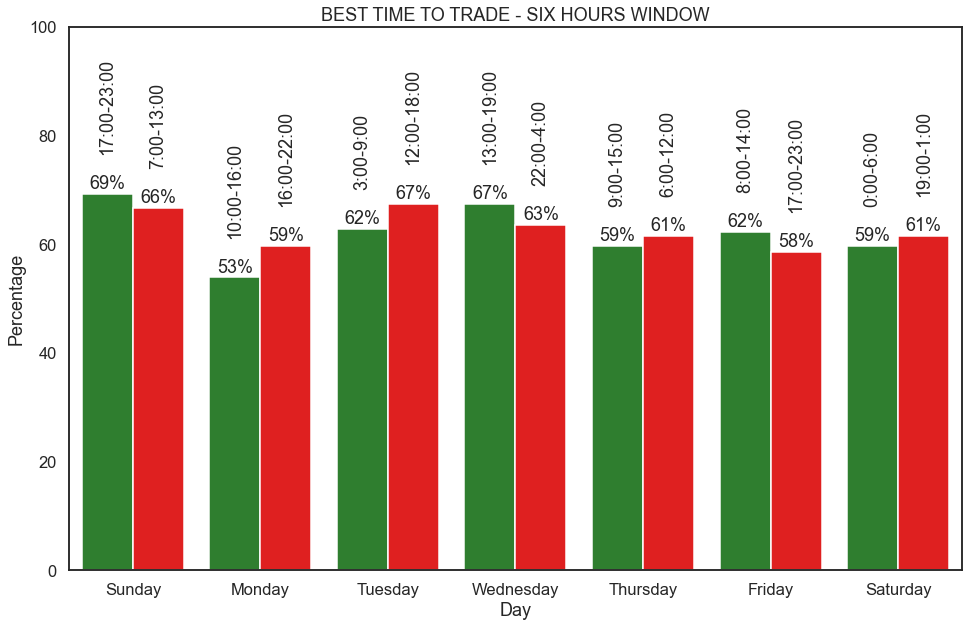

In [22]:
hourly6_pattern = get_pattern_for_window(scrip_1h_df,  groupbyday = True, window_period = 6)
best_hourly6_pattern = display_window_pattern(hourly6_pattern,"SIX HOURS WINDOW")

#### EIGHT-HOURS WINDOW

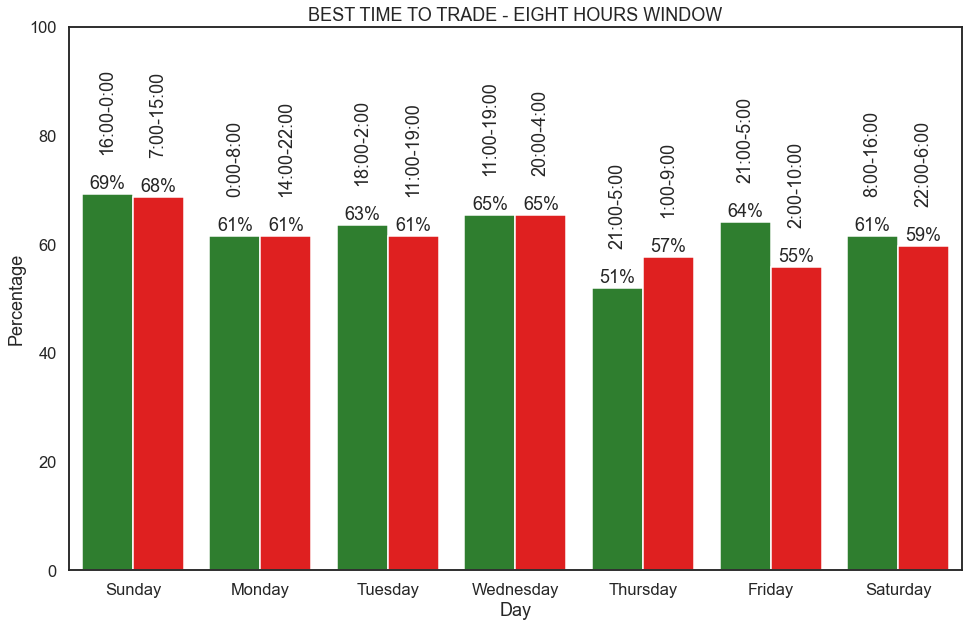

In [23]:
hourly8_pattern = get_pattern_for_window(scrip_1h_df,  groupbyday = True, window_period = 8)
best_hourly8_pattern = display_window_pattern(hourly8_pattern,"EIGHT HOURS WINDOW")

#### TWELVE-HOURS WINDOW

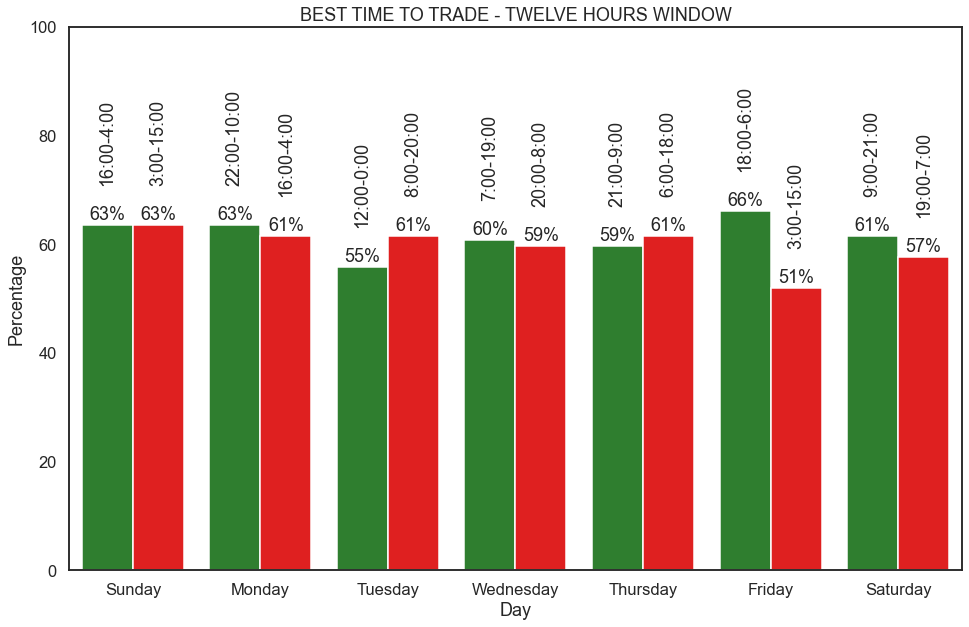

In [24]:
hourly12_pattern = get_pattern_for_window(scrip_1h_df,  groupbyday = True, window_period = 12)
best_hourly12_pattern = display_window_pattern(hourly12_pattern,"TWELVE HOURS WINDOW")

#### 1-DAY WINDOW

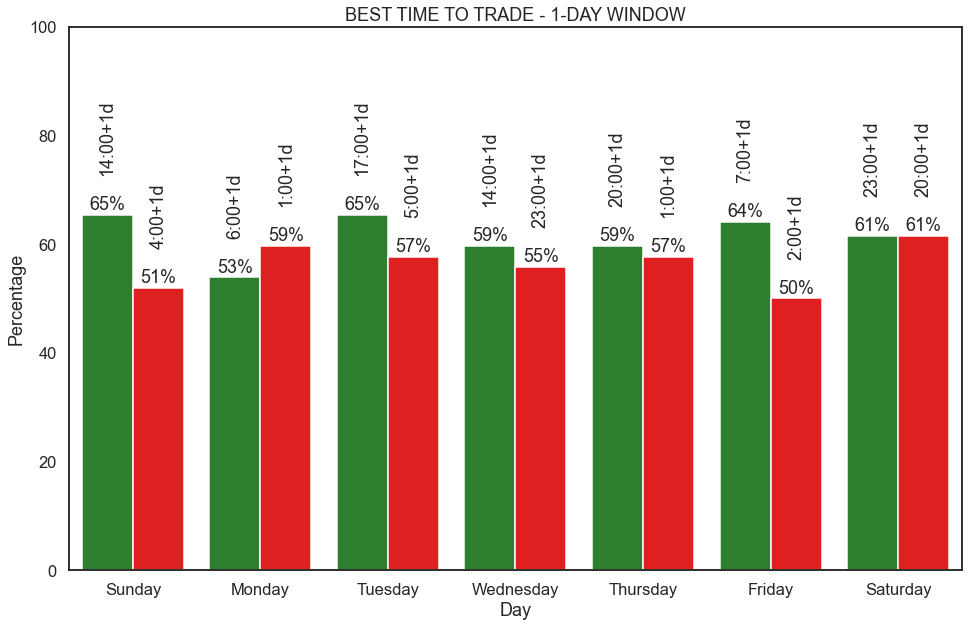

In [25]:
hourly24_pattern = get_pattern_for_window(scrip_1h_df,  groupbyday = True, window_period = 24)
best_hourly24_pattern = display_window_pattern(hourly24_pattern,"1-DAY WINDOW")

#### 2-DAYS WINDOW

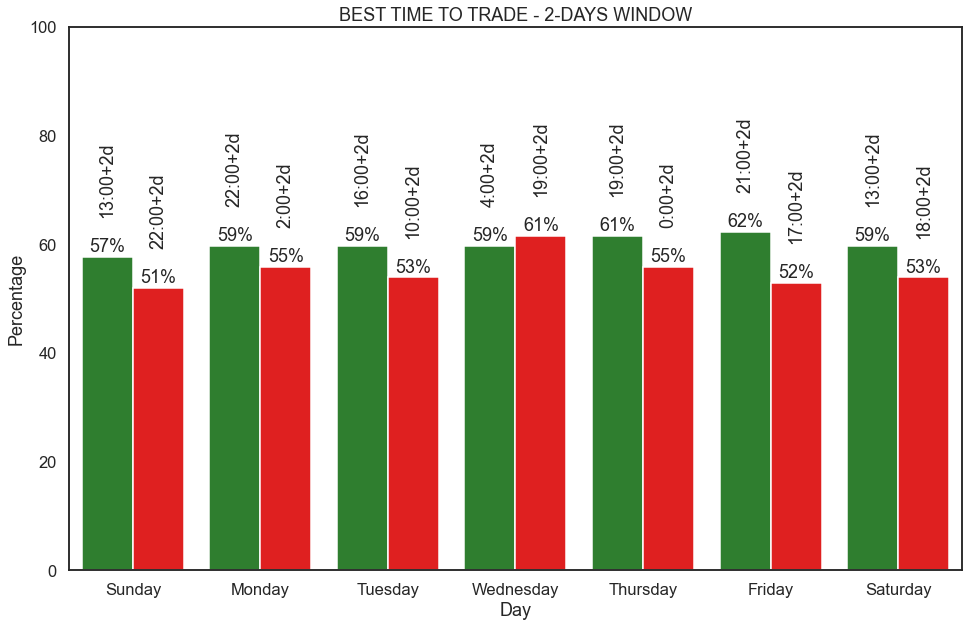

In [26]:
hourly48_pattern = get_pattern_for_window(scrip_1h_df,  groupbyday = True, window_period = 48)
best_hourly48_pattern = display_window_pattern(hourly48_pattern,"2-DAYS WINDOW")

### BEST TRADING TIME FOR A GIVEN DAY

In [27]:
TRADING_DAY = 'Saturday'
TRADING_WINDOW_HRS = 3

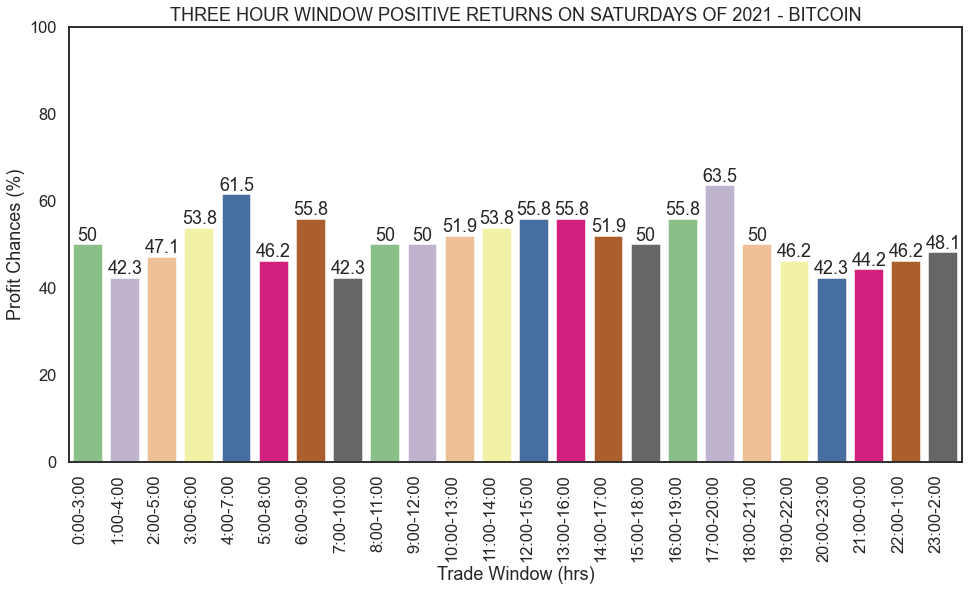

,window,profit_or_loss,percent,hour
hours,,,,
0:00-3:00,3,GREEN,50.0,0
1:00-4:00,3,GREEN,42.3,1
2:00-5:00,3,GREEN,47.1,2
3:00-6:00,3,GREEN,53.8,3
4:00-7:00,3,GREEN,61.5,4
5:00-8:00,3,GREEN,46.2,5
6:00-9:00,3,GREEN,55.8,6
7:00-10:00,3,GREEN,42.3,7
8:00-11:00,3,GREEN,50.0,8


In [28]:
day_scrip_df = scrip_1h_df[scrip_1h_df['day'] == TRADING_DAY]

sat_hourly_pattern = get_pattern_for_window(day_scrip_df,  groupbyday = False, window_period = TRADING_WINDOW_HRS)

sat_hourly_pattern['hour'] = sat_hourly_pattern['hours'].str.split(':',n=-1, expand=True)[0]
sat_hourly_pattern['hour'] = sat_hourly_pattern['hour'].astype(int)
sat_hourly_pattern = sat_hourly_pattern[sat_hourly_pattern['profit_or_loss'] == 'GREEN']
sat_hourly_pattern = sat_hourly_pattern.sort_values('hour').set_index('hours')
sat_hourly_pattern['percent'] = round(sat_hourly_pattern['percent'] ,1)


plot_data_bar(sat_hourly_pattern,'percent',
              f'THREE HOUR WINDOW POSITIVE RETURNS ON SATURDAYS OF 2021 - {scrip_name}',
              'Trade Window (hrs)','Profit Chances (%)',
              palette_type = 'Accent',
             show_yvalue = True, xticks_rotate = 90,ylimmax=100)


sat_hourly_pattern



### BEST TRADING TIME FOR EACH DAY IN THE WEEK

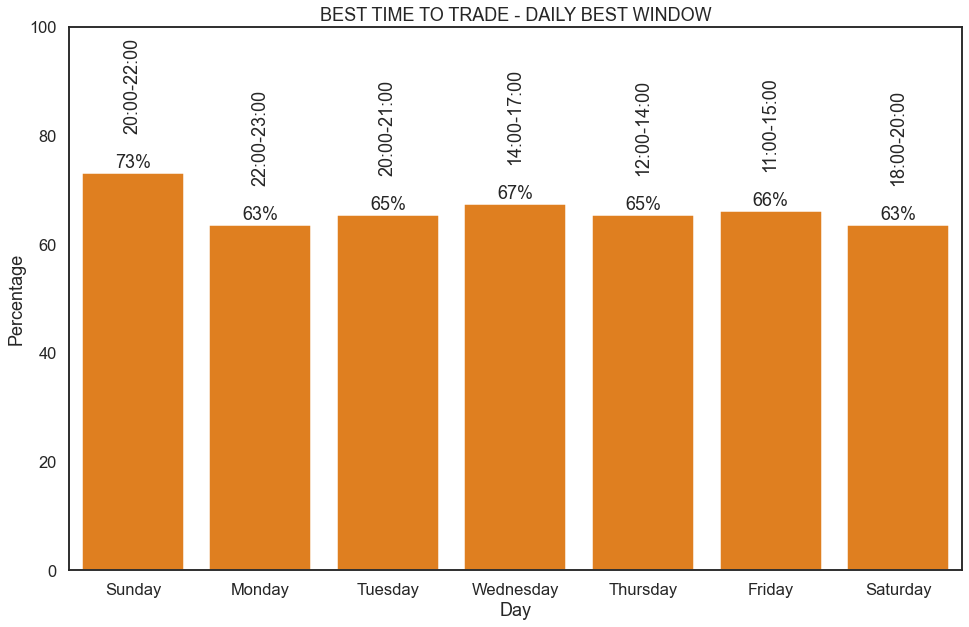

,day,hours,percent
0,Sunday,20:00-22:00,73.08
1,Monday,22:00-23:00,63.46
2,Tuesday,20:00-21:00,65.38
3,Wednesday,14:00-17:00,67.31
4,Thursday,12:00-14:00,65.38
5,Friday,11:00-15:00,66.04
6,Saturday,18:00-20:00,63.46


In [29]:

best_trading_window_df = pd.concat([best_hourly_pattern,best_hourly2_pattern,best_hourly3_pattern,best_hourly4_pattern,
           best_hourly6_pattern,best_hourly8_pattern,best_hourly12_pattern,best_hourly24_pattern])

best_trading_window_df = best_trading_window_df[best_trading_window_df['profit_or_loss'] == 'GREEN']


best_trading_window_df = best_trading_window_df.sort_values(['day','percent'], ascending=False) \
                               .drop_duplicates(['day'])
best_trading_window_df = best_trading_window_df.sort_values(['day']).reset_index(drop=True)

plot_best_time_window(best_trading_window_df, 'DAILY BEST WINDOW',hue_colors = 'autumn_r')

display(best_trading_window_df[['day','hours','percent']])


## TEST RESULTS

### TEST CONFIG

### PREPROCESS TEST DATA

In [30]:
test_df = preprocess(complete_1h_df, TEST_START_DATE, TEST_END_DATE)
test_df = add_timestamp_features(test_df)

### GET DETAILS ON TEST DATA BASED ON WINDOW OR DAY-WINDOW COMBINATION

In [31]:
def shift_close_price(x):
    shifted_price_col = f'next{x["window"]}_open' if x["window"] > 1 else 'close'
    return x[shifted_price_col]
    
def get_test_detailed_trade_df(test_data, window_period, best_timing_df, min_percent = 0):
    if window_period is None:
        test_data['window'] = test_data['day'].apply(
                                lambda x: best_trading_window_df[best_trading_window_df['day'] == x]['window'].iloc[0])
    else:
        test_data['window'] = window_period
    
    test_data = add_next_open_features(test_data)

    test_data['window_price'] = test_data.apply(shift_close_price,axis=1)
    test_data.reset_index(inplace=True)
    test_data = test_data[(test_data['window_price'].notna())]
    
    best_timing_df = best_timing_df[best_timing_df['profit_or_loss'] == 'GREEN']
    best_timing_df['hour'] = best_timing_df['hours'].str.split(':',n=-1, expand=True)[0]
    best_timing_df['hour'] = best_timing_df['hour'].astype(int)
    # Filter based on minimum percentage of GREENs to consider the trade timing
    best_timing_df = best_timing_df[best_timing_df['percent'] > min_percent]
     
    test_filtered_df = pd.merge(best_timing_df, test_data, on=['day','hour'], how='left')

    test_filtered_df['qty'] = INVESTMENT_AMOUNT_DOLLARS/test_filtered_df['open']
    test_filtered_df['profit_loss'] = test_filtered_df['qty'] * test_filtered_df['window_price'] - INVESTMENT_AMOUNT_DOLLARS
    
    if (window_period == 3) or (window_period == 4):
        # FOR DEBUGGING
        print(f'DAILY BEST TIMINGS FOR {window_period} HOURS WINDOW')
        display(best_timing_df[['day','hours','percent']])
        pl_df = pd.DataFrame(test_filtered_df.groupby('day')['profit_loss'].sum())
        pl_df.reset_index(inplace=True)
        display(pl_df)
        # test_data.to_csv(f"test_data_{window_period}.csv")
        # test_filtered_df.to_csv(f"test_filtered_{window_period}.csv")
        
    return test_filtered_df
    

def get_test_profit_loss(test_data, window_period, best_timing_df, min_percent = 0):
    test_filtered_df = get_test_detailed_trade_df(test_data, window_period, best_timing_df,min_percent)
    profit_loss = round(test_filtered_df['profit_loss'].sum(),2)
    return profit_loss
    

### TRADE DAILY FOR BEST TIMING IN THE GIVEN WINDOW PERIOD

DAILY BEST TIMINGS FOR 3 HOURS WINDOW


,day,hours,percent
0,Sunday,20:00-23:00,73.08
2,Monday,22:00-1:00,61.54
4,Tuesday,6:00-9:00,65.38
6,Wednesday,14:00-17:00,67.31
8,Thursday,11:00-14:00,63.46
10,Friday,22:00-1:00,62.26
12,Saturday,17:00-20:00,63.46


,day,profit_loss
0,Sunday,36.965200
1,Monday,35.591801
2,Tuesday,-1.000277
3,Wednesday,-5.226065
4,Thursday,6.493490
5,Friday,9.453708
6,Saturday,-1.900764


DAILY BEST TIMINGS FOR 4 HOURS WINDOW


,day,hours,percent
0,Sunday,19:00-23:00,71.15
2,Monday,21:00-1:00,57.69
4,Tuesday,5:00-9:00,59.62
6,Wednesday,14:00-18:00,67.31
8,Thursday,10:00-14:00,65.38
10,Friday,11:00-15:00,66.04
12,Saturday,15:00-19:00,57.69


,day,profit_loss
0,Sunday,17.492686
1,Monday,9.641380
2,Tuesday,1.198208
3,Wednesday,-15.889665
4,Thursday,1.645817
5,Friday,12.795758
6,Saturday,11.699085


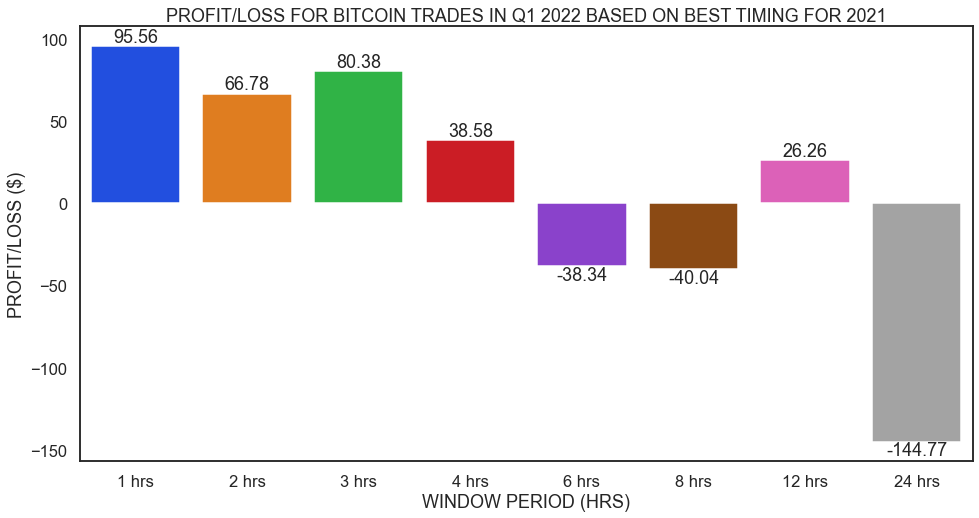

TOTAL PROFIT/LOSS:84.41$


,profit_loss
window_period,
1 hrs,95.56
2 hrs,66.78
3 hrs,80.38
4 hrs,38.58
6 hrs,-38.34
8 hrs,-40.04
12 hrs,26.26
24 hrs,-144.77


In [32]:
daily_trade_df = pd.DataFrame(columns = ['window_period','profit_loss'])
best_hourly_patterns = {
    1:best_hourly_pattern,
    2:best_hourly2_pattern,
    3:best_hourly3_pattern,
    4:best_hourly4_pattern,
    6:best_hourly6_pattern,
    8:best_hourly8_pattern,
    12:best_hourly12_pattern,
    24:best_hourly24_pattern,
    48:best_hourly48_pattern
}
for window_period in [1,2,3,4,6,8,12,24]:    
    daily_trade = {'window_period' : f'{window_period} hrs', 
                  'profit_loss' : get_test_profit_loss(test_df.copy(), 
                                                       window_period, 
                                                       best_hourly_patterns[window_period], 
                                                       min_percent = 55)}

    daily_trade_df=daily_trade_df.append(daily_trade,ignore_index=True)
    
daily_trade_df.set_index('window_period',inplace=True)

plot_data_bar(daily_trade_df,'profit_loss',
              f'PROFIT/LOSS FOR {scrip_name} TRADES IN Q1 2022 BASED ON BEST TIMING FOR 2021','WINDOW PERIOD (HRS)','PROFIT/LOSS ($)','bright', show_yvalue = True)
    
print(f"TOTAL PROFIT/LOSS:{round(daily_trade_df['profit_loss'].sum(),2)}$")    
display(daily_trade_df)


### TRADE DAILY FOR BEST TIMING FOR THAT DAY

'TOTAL PROFIT/LOSS: 73.8$'

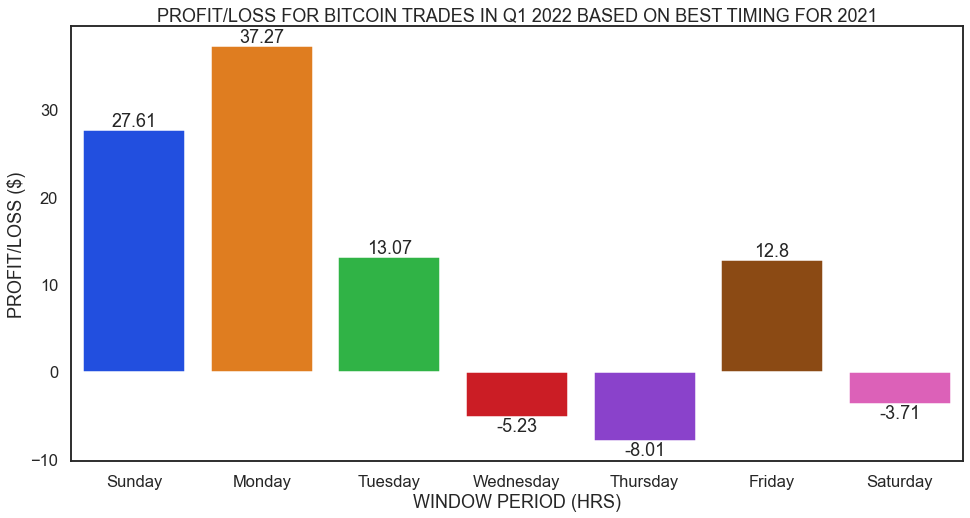

,profit_loss
day,
Sunday,27.61
Monday,37.27
Tuesday,13.07
Wednesday,-5.23
Thursday,-8.01
Friday,12.80
Saturday,-3.71


In [33]:
output = get_test_detailed_trade_df(test_df.copy(),None,best_trading_window_df)
daily_pl = pd.DataFrame(output.groupby(['day'])['profit_loss'].sum())
daily_pl['profit_loss'] = round(daily_pl['profit_loss'],2)

display(f"TOTAL PROFIT/LOSS: {round(daily_pl['profit_loss'].sum(),2)}$")
plot_data_bar(daily_pl,'profit_loss',
              f'PROFIT/LOSS FOR {scrip_name} TRADES IN Q1 2022 BASED ON BEST TIMING FOR 2021','WINDOW PERIOD (HRS)','PROFIT/LOSS ($)','bright', show_yvalue = True)

display(daily_pl)

